
# **Image Colorization With GANs**

GANs are the state-of-the-art machine learning models which can generate new data instances from existing ones. They use a very interesting technique, inspired from the Game Theory, to generate realistic samples. 

In this notebook, we'll use GANs to colorize a grayscale ( B/W ) image. In addition to that, our generator model will have a structure similar to that of a UNet i.e the one with skip connections.



## **1. Downloading and Processing the data**

A dataset of RGB images to train the GAN model whose images consists of various scenes/places.

* Download the dataset on your machine from [here](https://drive.google.com/file/d/1sQ5C8HiKVr2Edp3ojLLNauwRbOLfVn2q/view?usp=sharing). 
* Upload the downloaded `.zip` file here on Colab.








We'll now parse the images ( RGB images to be precise ) one by one, and transform each one to a grayscale image using PIL's `.convert( 'L' )` method. So our dataset will have samples of $( \ grayscale \ image \ , \ RGB \ image \ )$

We used only a part of our dataset, determined by `dataset_split` , as Colab's computational power would cease on providing a large number of images.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/butterflies/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/butterflies


In [3]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.8.0
Running on TPU  ['10.19.106.242:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.19.106.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.19.106.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [4]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
import os
from tensorflow import keras

# The batch size we'll use for training
batch_size = 64

# Size of the image required to train our model
img_size = 224

# These many images will be used from the data archive
dataset_split = 128

#master_dir = 'lineart'
x = []
y = []
# for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
#     lineart_image = Image.open( os.path.join( master_dir , image_file ) )#.resize( ( img_size , img_size ) )
#     # Normalize the RGB image array
#     lineart_img_array = (np.asarray( lineart_image ) ) / 255
#     gray_lineart = lineart_image.convert( 'L' )
#     # Normalize the grayscale image array
#     gray_lineart_array = ( np.asarray( gray_lineart ).reshape( ( img_size , img_size , 1 ) ) ) / 255
#     # Append both the image arrays
#     x.append( gray_lineart_array )
#     #y.append( rgb_img_array )

master_dir = 'processed'
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    rgb_image = Image.open( os.path.join( master_dir , image_file ) )#.resize( ( img_size , img_size ) )
    # Normalize the RGB image array
    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    gray_image = rgb_image.convert( 'L' )
    # Normalize the grayscale image array
    gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255
    # Append both the image arrays
    x.append( gray_img_array )
    y.append( rgb_img_array )
    
# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split( np.array(x) , np.array(y) , test_size=0.1, shuffle=False)

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices( ( train_x , train_y ) )
dataset = dataset.batch( batch_size )



## **2. The GAN**

In this section, we'll create our GAN model step-by-step with Keras. First, we'll implement the generator then the discriminator and finally the loss functions required by both of them.



### **A. Generator** 

Our generator ( represented as $G$ ) will take in grayscale image $x$ and produce a RGB image $G( x )$. Note, $x$ will be a tensor of shape $( \ batch \ size \ , \ 120 \ , \ 120 \ , \ 1 \ )$ and the output $G(x)$ will have a shape $( \ batch \ size \ , \ 120 \ , \ 120 \ , \ 3 \ )$

* Our generator will have a encoder-decoder structure, similar to the UNet architecture. Additionally, we use Dilated convolutions to have a larger receptive field.

* We introduce skip connections in our model so as to have better flow of information from the encoder to the decoder.


In [5]:
def get_generator_model():

    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model



### **B. Discriminator**

The discriminator model, represented as $D$, will take in the *real image* $y$ ( from the training data ) and the *generated image* $G(x)$ ( from the generator ) to output two probabilities.

* We train the discriminator in such a manner that is able to differentiate the *real images* and the generated *images*. So, we train the model such that $y$ produces a output of $1.0$ and $G(x)$ produces an output of $0.0$.
* Note that instead of using hard labels like $1.0$ and $0.0$, we use soft labels which are close to 1 and 0. So for a hard label of $1.0$, the soft label will be $(1 - \epsilon)$ where $\epsilon$ is picked uniformly from $( 0 , 0.1 ]$


In [6]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 224 , 224 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    return model



### **C. Loss Functions**

We'll now implement the loss functions for our GAN model. As you might know that we have two loss functions, one for the generator and another for the discriminator. 

* For our generator, we'll use the L2/MSE loss function.
* For optimization, we use the Adam optimizer with a learning rate of 0.0005



In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_generator_model()
discriminator = get_discriminator_model()



## **3. Training The GAN**

So finally, we'll train our GAN on the dataset, we prepared earlier.


In [8]:
@tf.function
def train_step( input_x , real_y ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
    
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))




Run the cell below, to start the training

In [9]:
num_epochs = 100

for e in range( num_epochs ):
    print( e )
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        print( x.shape )
        train_step( x , y )
        


0
(64, 224, 224, 1)
(51, 224, 224, 1)
1
(64, 224, 224, 1)
(51, 224, 224, 1)
2
(64, 224, 224, 1)
(51, 224, 224, 1)
3
(64, 224, 224, 1)
(51, 224, 224, 1)
4
(64, 224, 224, 1)
(51, 224, 224, 1)
5
(64, 224, 224, 1)
(51, 224, 224, 1)
6
(64, 224, 224, 1)
(51, 224, 224, 1)
7
(64, 224, 224, 1)
(51, 224, 224, 1)
8
(64, 224, 224, 1)
(51, 224, 224, 1)
9
(64, 224, 224, 1)
(51, 224, 224, 1)
10
(64, 224, 224, 1)
(51, 224, 224, 1)
11
(64, 224, 224, 1)
(51, 224, 224, 1)
12
(64, 224, 224, 1)
(51, 224, 224, 1)
13
(64, 224, 224, 1)
(51, 224, 224, 1)
14
(64, 224, 224, 1)
(51, 224, 224, 1)
15
(64, 224, 224, 1)
(51, 224, 224, 1)
16
(64, 224, 224, 1)
(51, 224, 224, 1)
17
(64, 224, 224, 1)
(51, 224, 224, 1)
18
(64, 224, 224, 1)
(51, 224, 224, 1)
19
(64, 224, 224, 1)
(51, 224, 224, 1)
20
(64, 224, 224, 1)
(51, 224, 224, 1)
21
(64, 224, 224, 1)
(51, 224, 224, 1)
22
(64, 224, 224, 1)
(51, 224, 224, 1)
23
(64, 224, 224, 1)
(51, 224, 224, 1)
24
(64, 224, 224, 1)
(51, 224, 224, 1)
25
(64, 224, 224, 1)
(51, 224, 224,


## **4. Results**

We plotted the input, output and the original images respectively, from a part of the dataset to find out the results.


In [10]:
y = generator( test_x[0 : ] ).numpy()

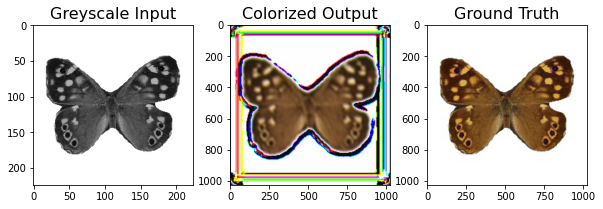

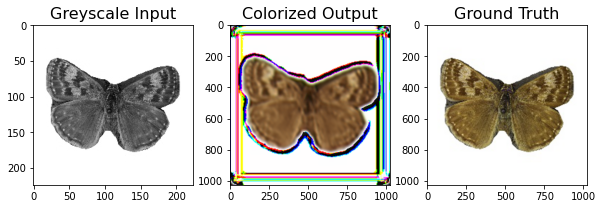

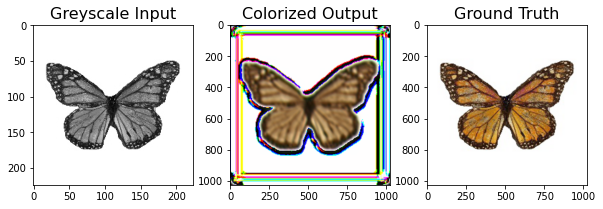

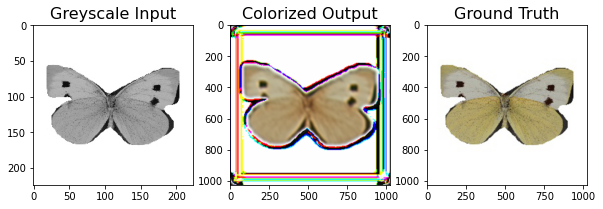

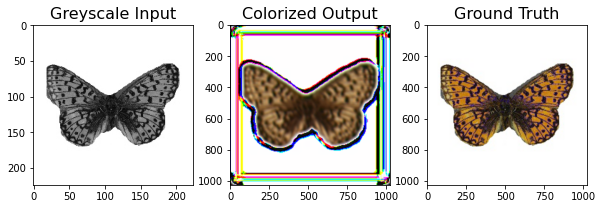

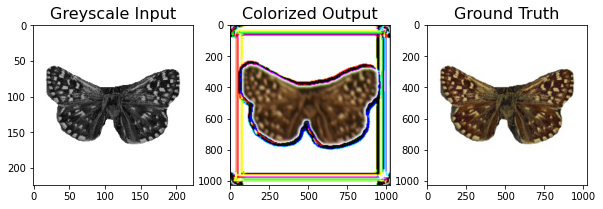

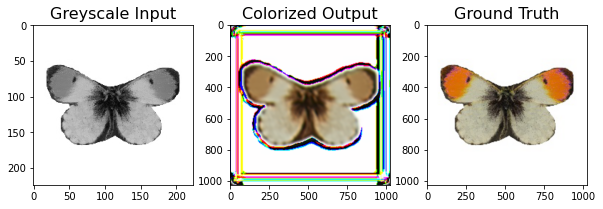

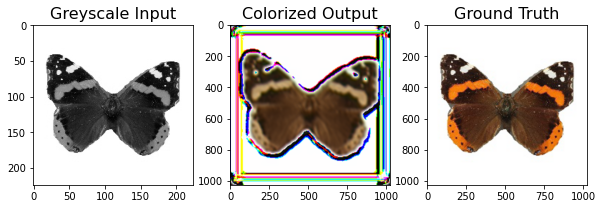

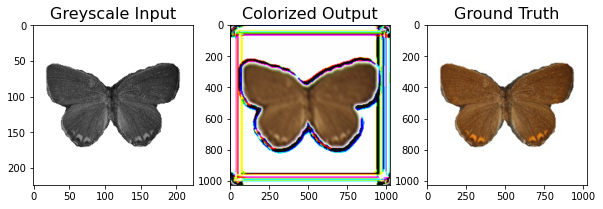

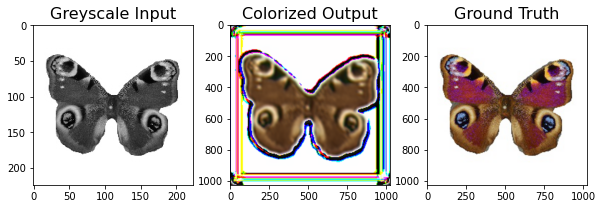

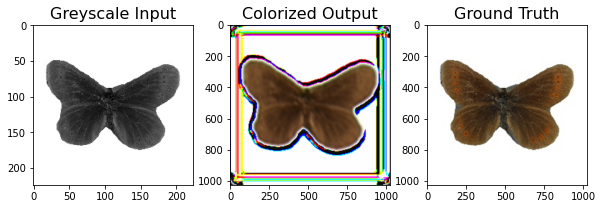

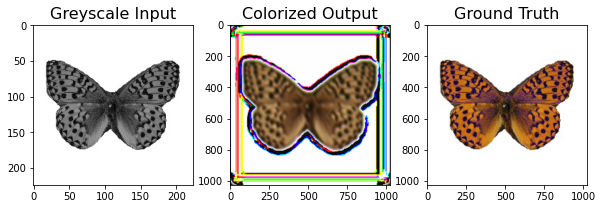

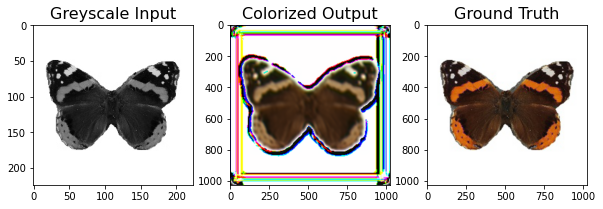

In [12]:
for i in range(len(test_x)):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Greyscale Input', fontsize=16)
  plt.imshow( test_x[i].reshape((224,224)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )


  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

  plt.show()

Therefore, the overwhelming reslts depicts the power of GANs and the disruption which can be broght through them.

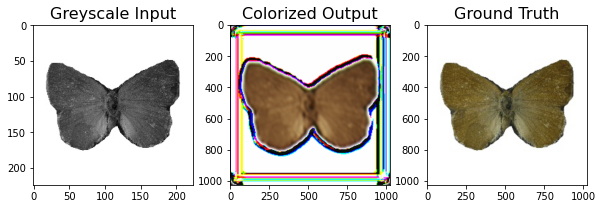

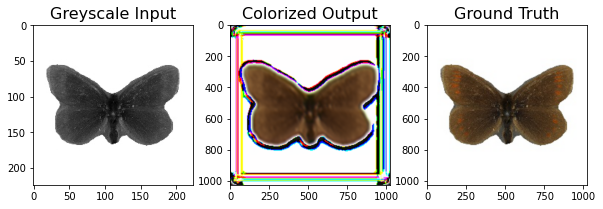

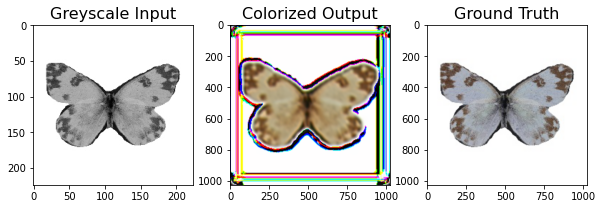

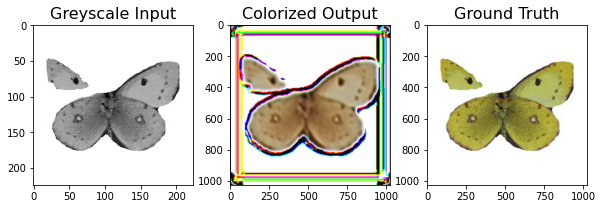

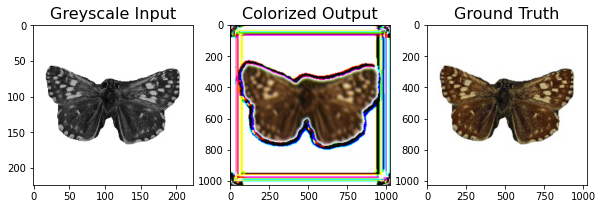

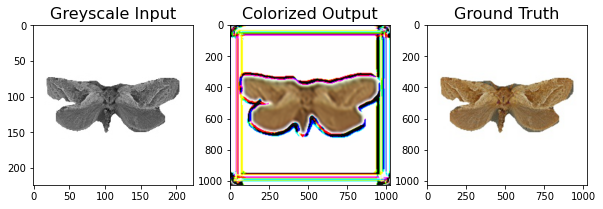

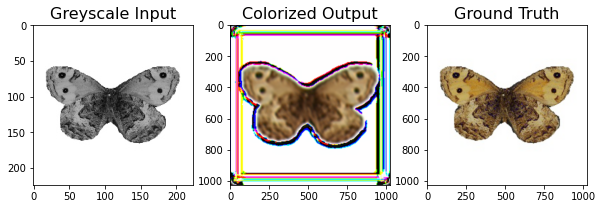

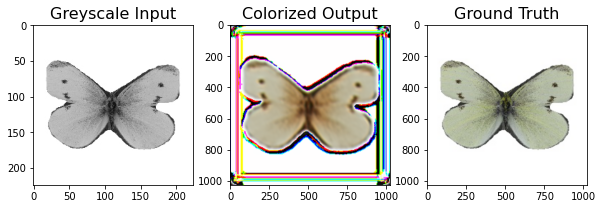

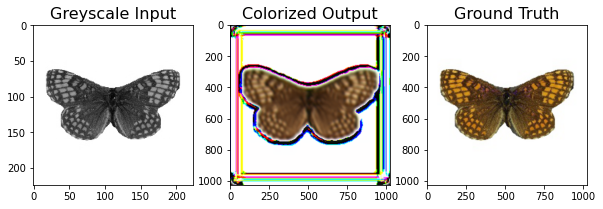

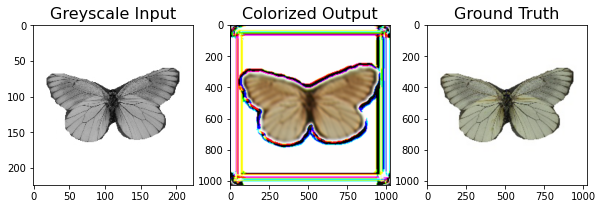

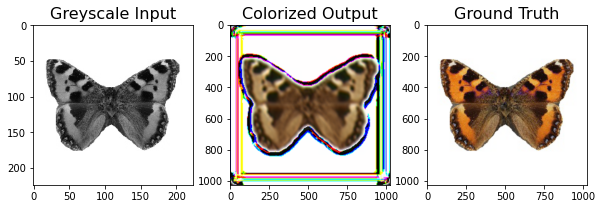

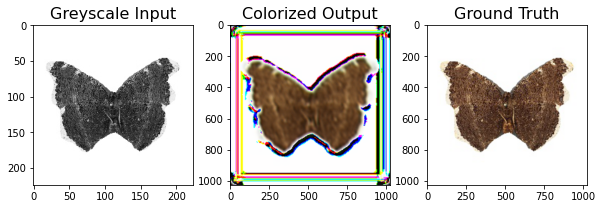

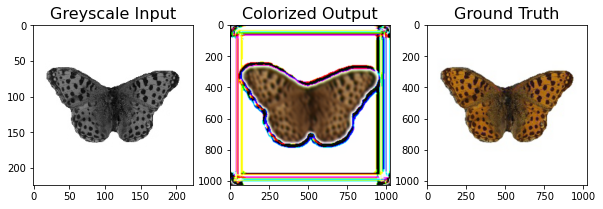

In [15]:
# Re-running on the training set 
y = generator( train_x[0 : ] ).numpy()
for i in range(len(test_x)):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Greyscale Input', fontsize=16)
  plt.imshow( train_x[i].reshape((224,224)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )


  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( train_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

  plt.show()